In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import json
from pprint import pprint
import re

## Define some utils

In [143]:
def is_conservative(s):
    # Define the pattern for "(union|intersection|setminus) X.[RL] X.[RL]"
    pattern_main = r'(union|intersection|setminus) (X\.R X\.L|X\.L X\.R)'
    
    # Find all occurrences of this pattern
    main_matches = re.findall(pattern_main, s)
    
    # Remove the matched main pattern from the string to check for the presence of X.R or X.L exclusively
    s_without_main = re.sub(pattern_main, '', s)
    
    # Check for exclusive presence of X.R or X.L in the rest of the string
    x_r_matches = re.findall(r'X\.R', s_without_main)
    x_l_matches = re.findall(r'X\.L', s_without_main)
    
    # Both X.R and X.L should not be present together
    # This returns False if either both are present or both are absent
    if bool(x_r_matches) == bool(x_l_matches):  
        return False
    
    # If all conditions are met, the string is conservative
    return len(main_matches)>0 

In [144]:
# Example usage
test_string = "This is an intersection X.R X.L example with X.R only X.L."
print(is_conservative(test_string))

False


In [147]:
print(is_conservative('λx.( not ( ( X.Q ( intersection X.L X.R ) ) X.L ) ) '))
print(is_conservative('λx.( not ( ( X.Q ( union X.R X.L ) ) X.R ) ) '))
print(is_conservative('λx.( ( X.Q X.L ) ( setminus X.L X.R ) ) '))
print(is_conservative('λx.( ( X.Q X.L ) ( union X.L X.R ) ) '))
print(is_conservative('λx.( ( X.Q X.L ) ( union X.R X.L ) ) '))
print(is_conservative('λx.( not ( ( X.Q ( setminus X.L X.R ) ) X.L ) ) '))
print(is_conservative('λx.( not ( ( X.Q ( setminus X.L X.L ) ) X.L ) ) '))
print(is_conservative('λx.( not ( ( X.Q ( setminus X.R X.R ) ) X.L ) ) '))

True
True
True
True
True
True
False
False


## Get data

In [148]:
datadir = "./../../data/second_test/run_"

In [106]:
data = []
for findex in range(1,17):
    fpath = datadir+str(findex)
    run = dict()
    with open(fpath+'/parameters.json','r') as openf:
        params = json.load(openf)
        run['params'] = params
    run['generation'] = []
    for genindex in range(200):
        try:
            with open(f'{fpath}/generation_{genindex}.json') as openf:
                run['generation'].append(json.load(openf))
        except FileNotFoundError:
            pass
    data.append(run)

In [107]:
reshuffled_data = []
for expi, exp in enumerate(data):
    for geni, gen in enumerate(exp['generation']):
        for childi, child in enumerate(gen['children']):
            original = None
            try:
                original = child['originalHypothesis']
            except:
                pass
            reshuffled_data.append({
                'exp': expi,
                'gen': geni,
                'child': childi,
                'hyp': child['hypothesis'],
                'commAcc': child['commAcc'],
                'parent': child['parentIndex'] if geni>0 else None,
                'original': original
            })
reshuffled_data = pd.DataFrame(reshuffled_data)
reshuffled_data[['comp', 'Q1', 'Q2', 'Q3']] = reshuffled_data.hyp.str.split('|',expand=True)

In [89]:
reshuffled_data = reshuffled_data[reshuffled_data['gen']<=86]

In [149]:
reshuffled_data['conservative'] = reshuffled_data.comp.apply(is_conservative)

In [150]:
reshuffled_data

,exp,gen,child,hyp,commAcc,parent,original,comp,Q1,Q2,Q3,conservative
0,0,0,0,λx.( ( X.Q X.L ) X.R ) | ( intGt ( cardinality...,-296.853502,NaN,None,λx.( ( X.Q X.L ) X.R ),( intGt ( cardinality X.L X.c ) 1 ),( intGt 1 ( + ( cardinality X.R X.c ) ( cardi...,( intEq ( cardinality X.L X.c ) 1 ),False
1,0,0,1,λx.( and ( and ( and ( and ( intGt 0 1 ) ( int...,-332.830880,NaN,None,λx.( and ( and ( and ( and ( intGt 0 1 ) ( int...,( intEq 0 ( cardinality X.L X.c ) ),( not ( or ( intGt 0 0 ) ( not ( intGt 0 ( + ...,( intEq ( cardinality X.L X.c ) ( cardinality...,False
2,0,0,2,λx.( intEq 1 1 ) | ( intEq ( cardinality X.L X...,-318.882575,NaN,None,λx.( intEq 1 1 ),( intEq ( cardinality X.L X.c ) ( - ( cardina...,( intEq ( cardinality X.L X.c ) ( cardinality...,( and ( intEq 1 ( cardinality X.L X.c ) ) ( i...,False
3,0,0,3,λx.( ( X.Q X.R ) X.L ) | ( not ( intEq ( cardi...,-286.411214,NaN,None,λx.( ( X.Q X.R ) X.L ),( not ( intEq ( cardinality X.L X.c ) 1 ) ),( intEq 1 ( cardinality X.L X.c ) ),( intGt ( - ( cardinality X.R X.c ) ( cardina...,False
4,0,0,4,λx.( intGt ( + 0 1 ) 0 ) | ( not ( intEq ( car...,-332.745519,NaN,None,λx.( intGt ( + 0 1 ) 0 ),( not ( intEq ( cardinality X.R X.c ) 1 ) ),( intEq ( cardinality X.L X.c ) ( cardinality...,( intGt ( cardinality X.L X.c ) ( + ( cardina...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
10715,15,100,5,λx.( intEq ( cardinality X.L X.c ) 1 ) | ( int...,-299.937839,0.0,None,λx.( intEq ( cardinality X.L X.c ) 1 ),( intGt ( cardinality X.L X.c ) ( cardinality...,( intEq ( cardinality X.L X.c ) ( cardinality...,( intGt ( cardinality X.L X.c ) ( cardinality...,False
10716,15,100,6,λx.( intEq ( cardinality X.L X.c ) 1 ) | ( int...,-284.306686,0.0,None,λx.( intEq ( cardinality X.L X.c ) 1 ),( intEq ( cardinality X.L X.c ) ( cardinality...,( intGt ( cardinality X.R X.c ) ( cardinality...,( intEq ( cardinality X.L X.c ) ( cardinality...,False
10717,15,100,7,λx.( intEq 1 ( cardinality X.L X.c ) ) | ( int...,-288.495839,2.0,None,λx.( intEq 1 ( cardinality X.L X.c ) ),( intGt ( cardinality X.L X.c ) ( cardinality...,( intGt ( cardinality X.L X.c ) ( cardinality...,( intEq ( cardinality X.L X.c ) ( cardinality...,False
10718,15,100,8,λx.( intEq 1 ( cardinality X.L X.c ) ) | ( int...,-307.624875,9.0,None,λx.( intEq 1 ( cardinality X.L X.c ) ),( intGt ( cardinality X.R X.c ) ( cardinality...,( intEq ( cardinality X.R X.c ) ( cardinality...,( intGt ( cardinality X.R X.c ) ( cardinality...,False


## Plot comm accuracy by conservativity

<Axes: xlabel='commAcc', ylabel='Density'>

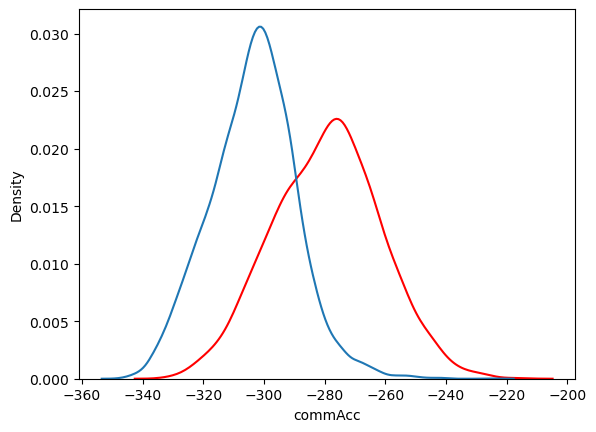

In [151]:
sns.kdeplot(reshuffled_data.commAcc[reshuffled_data.conservative], color='red')
sns.kdeplot(reshuffled_data.commAcc[np.logical_not(reshuffled_data.conservative)])

## Plot baseline vs evolved frequency of conservativity 

In [160]:
baseline = reshuffled_data[reshuffled_data.gen==0].conservative.mean()
evolved = reshuffled_data.conservative.mean()

print('baseline: ', baseline)
print('evolved:  ', evolved)
print(evolved/baseline)

baseline:  0.0375
evolved:   0.1605410447761194
4.281094527363185


## Plot evolution of conservativity

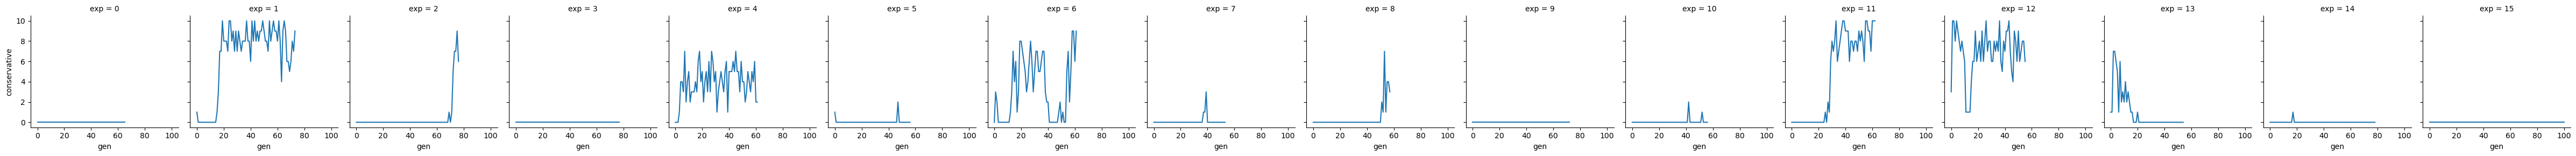

In [164]:
g = sns.FacetGrid(
    reshuffled_data.groupby(['gen','exp']).conservative.sum().reset_index(),
    col='exp'
)

g.map_dataframe(
    sns.lineplot,
    x='gen',
    y='conservative'
)

<Axes: xlabel='gen', ylabel='conservative'>

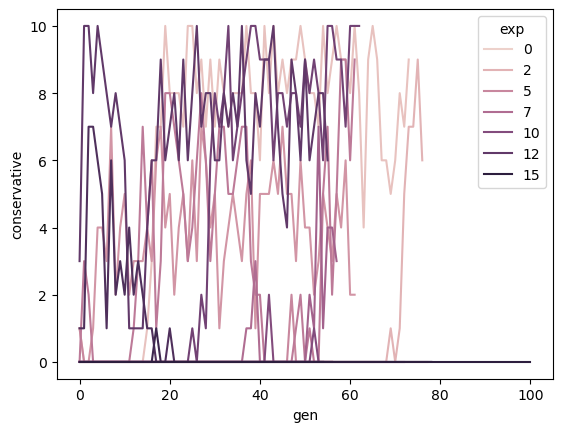

In [153]:
sns.lineplot(
    reshuffled_data.groupby(['gen','exp']).conservative.sum().reset_index(),
    x='gen',
    y='conservative',
    hue='exp'
)
# plt.plot(reshuffled_data.groupby('gen').size())

In [154]:
reshuffled_data.groupby(['gen']).conservative.size()

gen
0      160
1      160
2      160
3      160
4      160
      ... 
96      10
97      10
98      10
99      10
100     10
Name: conservative, Length: 101, dtype: int64

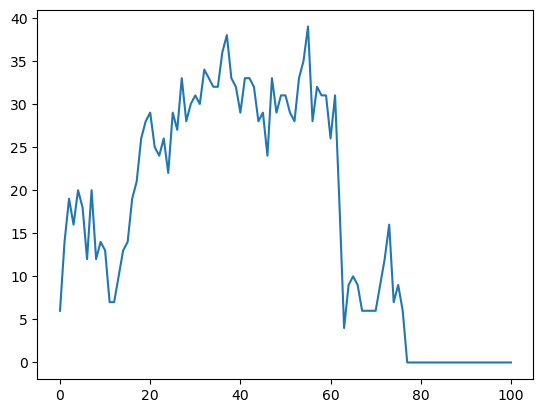

In [155]:
plt.plot(reshuffled_data.groupby(['gen']).conservative.sum())

In [156]:
def calculate_unique(x):
    y, counts = np.unique(x.comp,return_counts=True)
    pprint(list(zip(counts[np.argsort(counts)],y[np.argsort(counts)])))
    return y

reshuffled_data.groupby(['gen']).apply(calculate_unique)

[(1, 'λx.( ( X.Q ( intersection X.L X.L ) ) ( setminus X.R X.R ) ) '),
 (1, 'λx.( intGt ( cardinality ( nTh 1 X.c X.R ) X.c ) ( + 0 0 ) ) '),
 (1,
  'λx.( intGt ( - 1 ( - 0 ( cardinality ( setminus X.L X.L ) X.c ) ) ) ( '
  'cardinality X.L X.c ) ) '),
 (1, 'λx.( intGt ( + 0 1 ) 0 ) '),
 (1, 'λx.( intEq 1 ( - ( cardinality X.L X.c ) 0 ) ) '),
 (1, 'λx.( intEq ( cardinality X.R X.c ) 1 ) '),
 (1, 'λx.( intEq ( cardinality X.R X.c ) ( cardinality X.R X.c ) ) '),
 (1, 'λx.( intEq ( cardinality X.L X.c ) 1 ) '),
 (1,
  'λx.( intEq ( cardinality ( nTh 1 X.c X.L ) X.c ) ( + ( cardinality X.L X.c '
  ') 1 ) ) '),
 (1,
  'λx.( intEq ( cardinality ( nTh ( cardinality X.R X.c ) X.c X.R ) X.c ) ( '
  'cardinality X.R X.c ) ) '),
 (1, 'λx.( intEq ( - 1 1 ) 0 ) '),
 (1,
  'λx.( or ( intEq 0 ( cardinality X.R X.c ) ) ( intEq ( + 0 1 ) ( cardinality '
  'X.R X.c ) ) ) '),
 (1, 'λx.( intEq ( - 0 0 ) 0 ) '),
 (1, 'λx.( intEq ( - ( cardinality X.L X.c ) ( cardinality X.R X.c ) ) 0 ) '),
 (1, 'λx.( intEq

gen
0      [λx.( ( X.Q ( intersection X.L X.L ) ) ( setmi...
1      [λx.( ( X.Q ( nTh ( - ( cardinality ( intersec...
2      [λx.( ( X.Q ( intersection X.R X.L ) ) X.L ) ,...
3      [λx.( ( X.Q ( intersection X.L X.R ) ) X.L ) ,...
4      [λx.( ( X.Q ( intersection X.L X.R ) ) X.L ) ,...
                             ...                        
96     [λx.( ( X.Q X.L ) X.L ) , λx.( intEq ( cardina...
97     [λx.( intEq ( cardinality X.L X.c ) 1 ) , λx.(...
98     [λx.( ( X.Q X.L ) X.L ) , λx.( intEq ( cardina...
99     [λx.( ( X.Q X.L ) X.L ) , λx.( ( X.Q X.L ) X.R...
100    [λx.( intEq ( cardinality X.L X.c ) 1 ) , λx.(...
Length: 101, dtype: object

## Explore individual generations

In [165]:
df_plot = reshuffled_data[reshuffled_data['exp']==13]

(-2.0, 55.0)

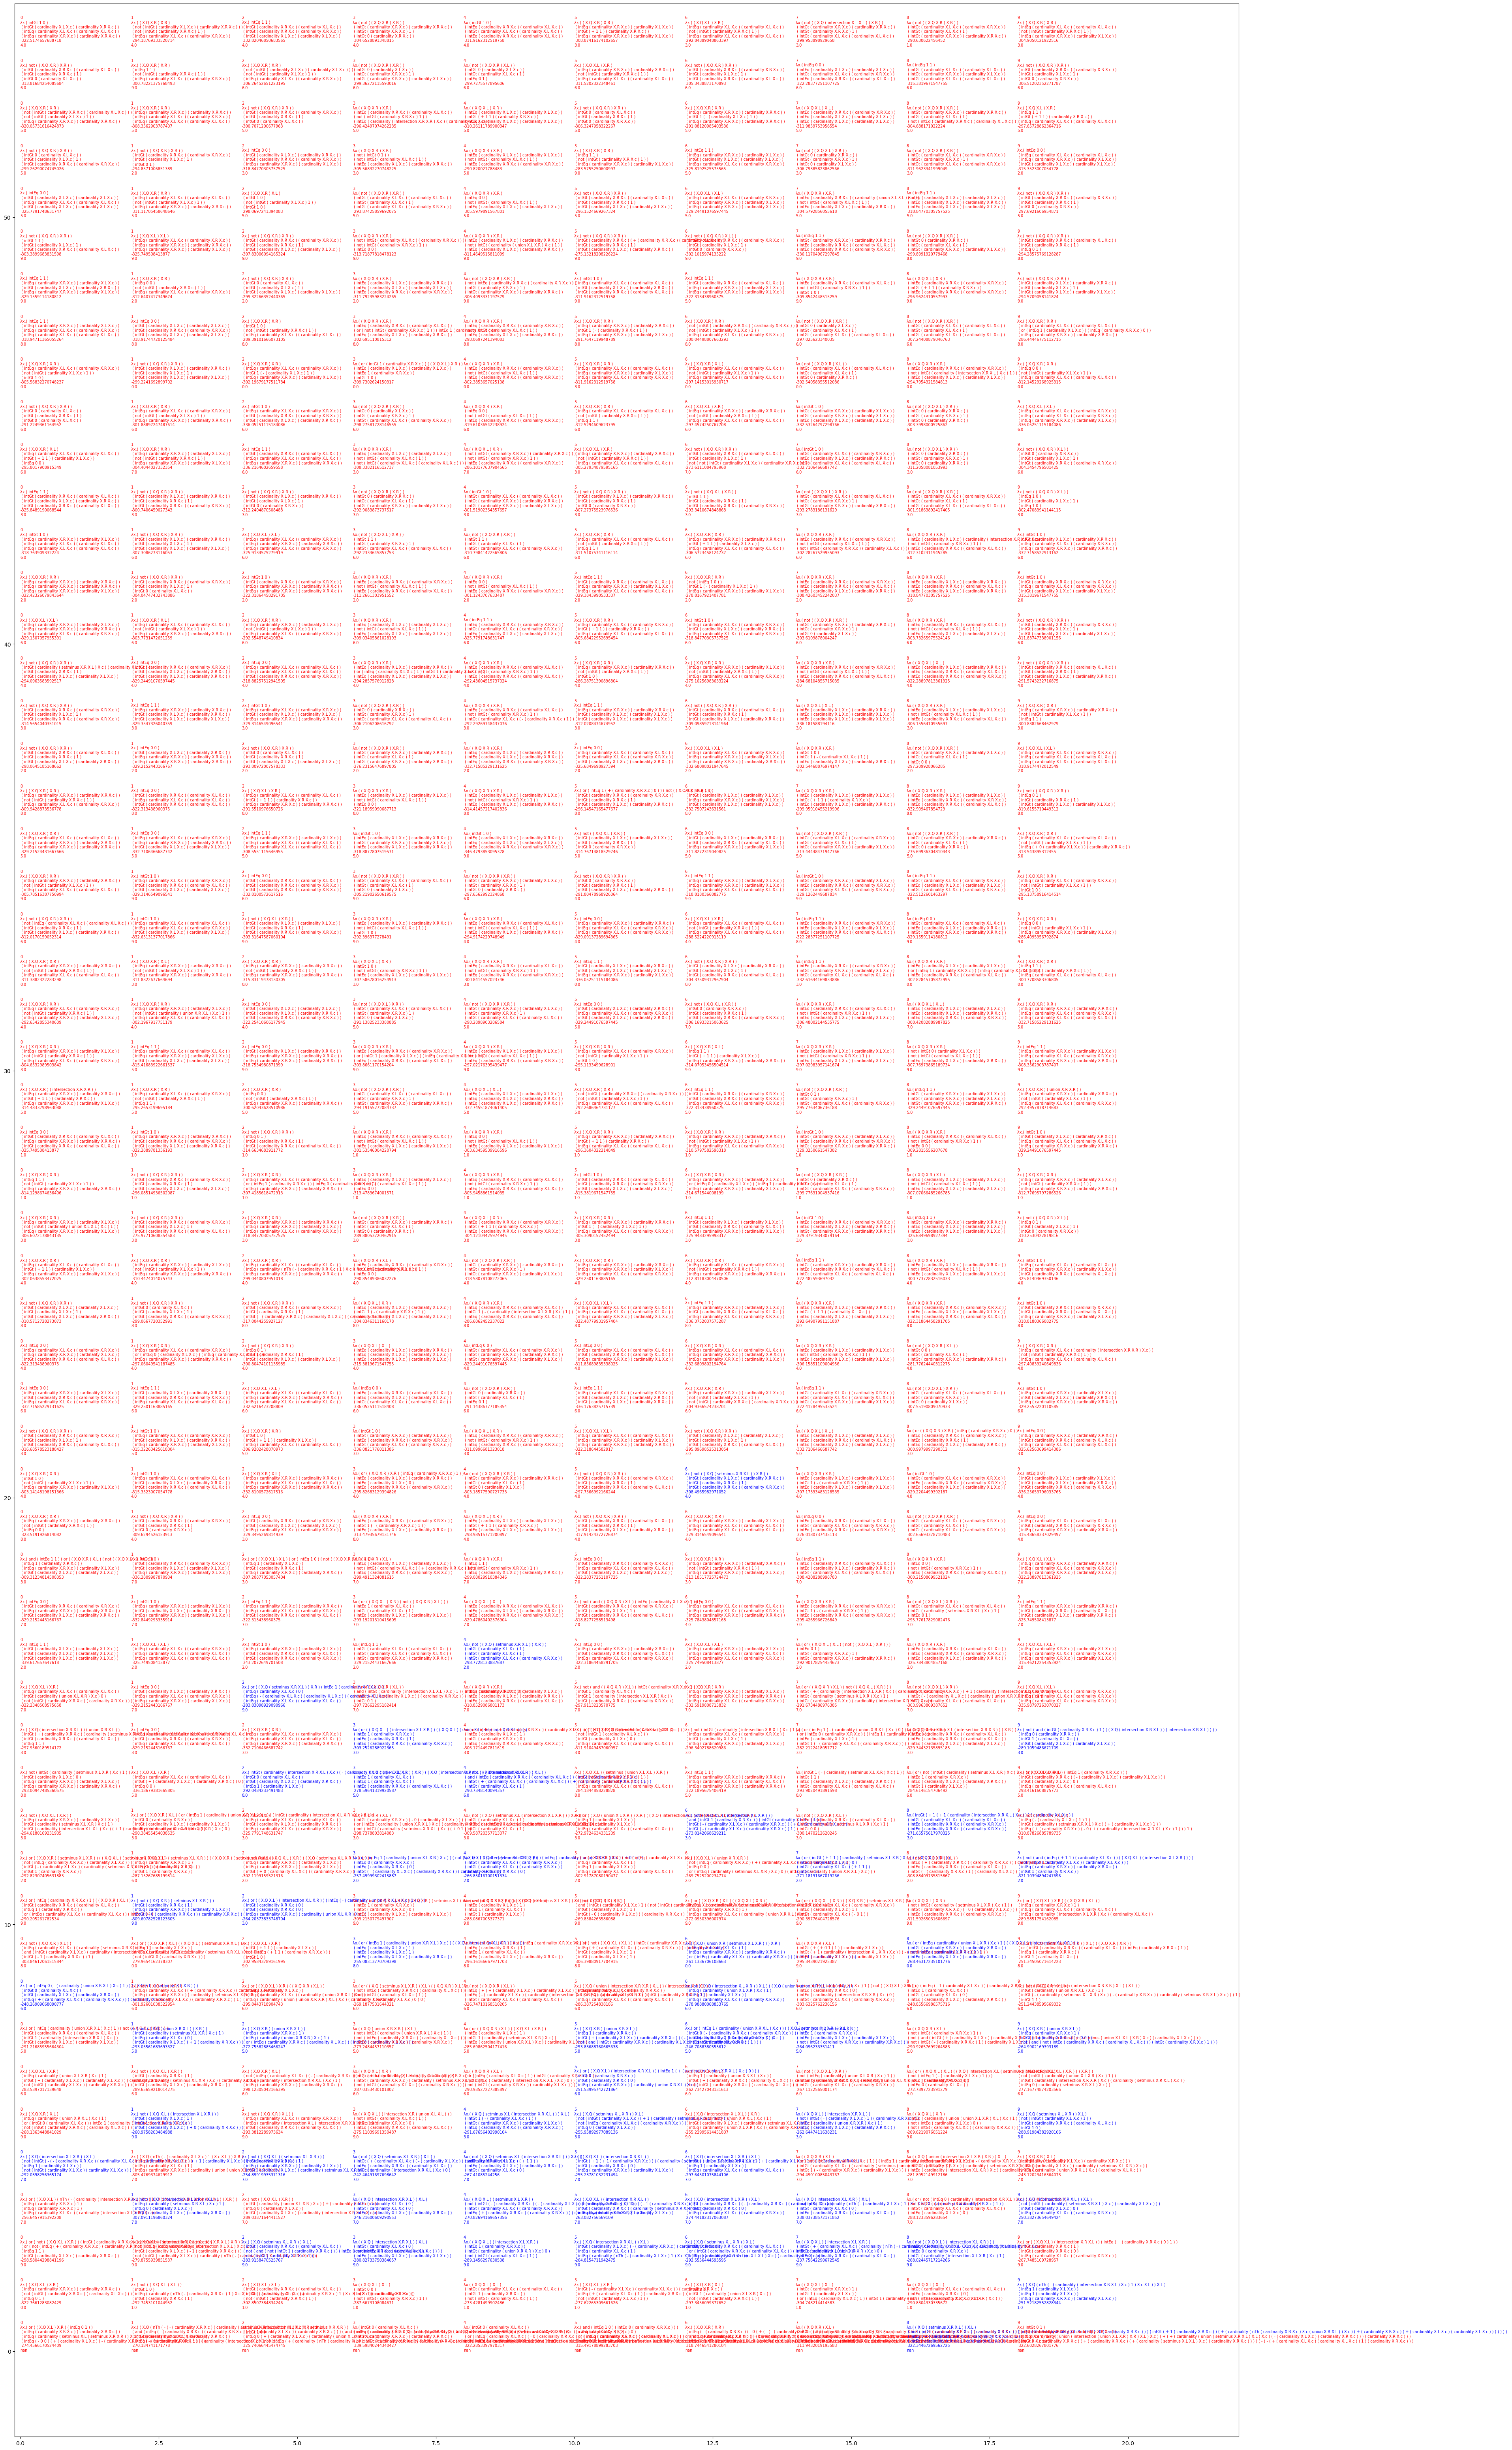

In [166]:
fig,ax = plt.subplots(figsize=(40,80))
for i, agent in df_plot.iterrows():
    color = 'blue' if agent.conservative else 'red'
    text = (
        str(agent.child)
        + '\n'
        + agent.comp
        +'\n'
        +str(agent.Q1)
        + '\n'
        +str(agent.Q2)
        + '\n'
        +str(agent.Q3)
        + '\n'
        +str(agent.commAcc)
        +'\n'+str(agent.parent)
    )
    ax.text(
        agent.child*2, 
        agent.gen, 
        text,
        color=color,
        fontsize='x-small'
    )
ax.set_xlim(-0.1,22)
ax.set_ylim(-2,df_plot.gen.max()+1)

In [ ]:
run 4: generation 3, agent 4 --> data for generation 4, agent 1

In [58]:
pprint(data[4]['generation'][3]['children'][4]['hypothesis'].split('|'))

['λx.( ( X.Q ( intersection X.L X.R ) ) X.R ) ',
 ' ( intGt 1 ( cardinality X.L X.c ) ) ',
 ' ( intEq ( cardinality X.L X.c ) ( cardinality X.L X.c ) ) ',
 ' ( intEq ( cardinality X.R X.c ) 1 )']


In [56]:
data[4]['generation'][4]['children'][1]['learningData']

['[DATA: { (-4, 0), (1, 1), (7, 1), (8, 0), (10, 0),  } -> ( ( Q1 target ) even ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-9, 0), (0, 0), (5, 1), (9, 0), (10, 1),  } -> ( something 0 ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-8, 0), (2, 0), (4, 0), (6, 1), (8, 1),  } -> ( ( Q1 target ) prime ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-10, 1), (-7, 0), (-6, 1), (-4, 1), (-1, 0),  } -> ( ( Q1 even ) distractor ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-5, 1), (1, 0), (2, 0), (3, 0), (8, 0),  } -> ( ( Q3 0 ) target ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-6, 0), (-2, 0), (1, 1), (3, 1), (9, 0),  } -> ( l_not ( ( Q3 distractor ) 5 ) ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-9, 0), (-8, 1), (-7, 0), (1, 0), (5, 0),  } -> ( ( Q3 prime ) target ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-8, 1), (-5, 0), (1, 0), (4, 0), (7, 1),  } -> ( ( Q3 9 ) 1 ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-10, 1), (-9, 0), (4, 1), (5, 0), 